In [95]:
import math
from random import random
from functools import partial
from collections import namedtuple

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm
import os

import numpy as np


from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance
from torch.optim import Adam
from ema_pytorch import EMA
from pathlib import Path

from torch.utils.data import Dataset, DataLoader

In [25]:

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)

class WeightStandardizedConv2d(nn.Conv1d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv1d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv1d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale        

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c n -> b (h c) n', h = self.heads)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b (h d) n')
        return self.to_out(out)

# model


In [26]:

class Unet1D(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 1,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv1d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [ ]:

class Unet1D_Conditioned(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 1,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv1d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [27]:

# gaussian diffusion trainer class

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)




In [28]:
class GaussianDiffusion1D(nn.Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        loss_type = 'l1',
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 0.,
        auto_normalize = True
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels
        self.self_condition = self.model.self_condition

        self.seq_length = seq_length

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate loss weight

        snr = alphas_cumprod / (1 - alphas_cumprod)

        if objective == 'pred_noise':
            loss_weight = torch.ones_like(snr)
        elif objective == 'pred_x0':
            loss_weight = snr
        elif objective == 'pred_v':
            loss_weight = snr / (snr + 1)

        register_buffer('loss_weight', loss_weight)

        # whether to autonormalize

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, x_self_cond = None, clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t, x_self_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond)

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16):
        seq_length, channels = self.seq_length, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, seq_length))

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.full((b,), t, device = device)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        x_start = None

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, i, self_cond)

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')

    def p_losses(self, x_start, t, noise = None):
        b, c, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = self.loss_fn(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)

In [6]:
import pandas as pd

df = pd.read_csv('../data/apartment_autoencoder.csv', index_col = 0, parse_dates = True)

data = df.values

BATCH_SIZE = 32

sample = data[:BATCH_SIZE,:]

# to torch tensor

sample = torch.tensor(sample, dtype = torch.float32)

# add channel dimension

sample = sample.unsqueeze(1)

sample.shape

torch.Size([32, 1, 24])

In [7]:
time = torch.randint(2,(BATCH_SIZE, ))

In [8]:
time

tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1])

In [9]:
model = Unet1D(dim = sample.shape[-1])

In [10]:
model(sample, time).shape

torch.Size([32, 1, 24])

In [11]:
diffusion = GaussianDiffusion1D(model, seq_length = 24, loss_type = 'l1', objective = 'pred_noise')

In [62]:
loss = diffusion(sample)

In [64]:
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
class DatasetDDPM(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.load_table = self._load_data(data_dir)

    def __len__(self):
        return self.load_table.shape[0]

    def __getitem__(self, idx):
        input_chunk = self.load_table[idx,:]
        return input_chunk
        
    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join(data_dir, 'apartment_autoencoder.csv'), index_col=0, parse_dates=True)
        return df.values


class DataloaderDDPM(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        input_chunks = zip(*batch)
        input_chunks= np.stack(input_chunks, axis=1)
        input_tensor = torch.FloatTensor(input_chunks)
        input_tensor = input_tensor.unsqueeze(1)
        return input_tensor


In [100]:
class DatasetDDPM_Conditioned(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.load_table = self._load_data(data_dir)

    def __len__(self):
        return self.load_table.shape[0]

    def __getitem__(self, idx):
        series = self.load_table[idx,:-3]
        labels = self.load_table[idx,-3:]
        return series, labels
        
    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join(data_dir, 'apartment_load_data_hourly_not_augmented.csv'), index_col=0, parse_dates=True)
        return df.values


class DataloaderDDPM_Conditioned(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        series, labels  = zip(*batch)
        series = np.stack(series, axis=1)
        series_tensor = torch.FloatTensor(series)
        series_tensor = series_tensor.unsqueeze(1)
        labels = np.stack(labels, axis=1)
        labels_tensor = torch.FloatTensor(labels)
        return series_tensor, labels_tensor


In [101]:
ds = DatasetDDPM_Conditioned('../data/')
dl = DataloaderDDPM_Conditioned(ds, batch_size = 32, shuffle = True)

In [102]:
for i, (series, labels) in enumerate(dl):
    print(series.shape)
    print(labels.shape)
    break

torch.Size([24, 1, 32])
torch.Size([3, 32])


In [51]:
from accelerate import Accelerator

acc = Accelerator(
    split_batches = True,
    mixed_precision = 'no'
)

__version__ = '1.5.4'

In [68]:
# trainer class
class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        amp = False,
        fp16 = False,
        split_batches = True,
        convert_image_to = None,
        calculate_fid = True,
        inception_block_idx = 2048
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = 'fp16' if fp16 else 'no'
        )

        self.accelerator.native_amp = amp

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels

        # InceptionV3 for fid-score computation

        self.inception_v3 = None

        if calculate_fid:
            assert inception_block_idx in InceptionV3.BLOCK_INDEX_BY_DIM
            block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[inception_block_idx]
            self.inception_v3 = InceptionV3([block_idx])
            self.inception_v3.to(self.device)

        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.seq_length

        # dataset and dataloader

        self.ds = DatasetDDPM(folder)
        dl = DataloaderDDPM(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers =0)

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
            'version': __version__
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    @torch.no_grad()
    def calculate_activation_statistics(self, samples):
        assert exists(self.inception_v3)

        features = self.inception_v3(samples)[0]
        features = rearrange(features, '... 1 1 -> ...')

        mu = torch.mean(features, dim = 0).cpu()
        sigma = torch.cov(features).cpu()
        return mu, sigma

    def fid_score(self, real_samples, fake_samples):

        if self.channels == 1:
            real_samples, fake_samples = map(lambda t: repeat(t, 'b 1 ... -> b c ...', c = 3), (real_samples, fake_samples))

        min_batch = min(real_samples.shape[0], fake_samples.shape[0])
        real_samples, fake_samples = map(lambda t: t[:min_batch], (real_samples, fake_samples))

        m1, s1 = self.calculate_activation_statistics(real_samples)
        m2, s2 = self.calculate_activation_statistics(fake_samples)

        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        return fid_value

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                accelerator.clip_grad_norm_(self.model.parameters(), 1.0)
                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and self.step % self.save_and_sample_every == 0:
                        self.ema.ema_model.eval()

                        with torch.no_grad():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))
                        self.save(milestone)

                        # whether to calculate fid

                        if exists(self.inception_v3):
                            fid_score = self.fid_score(real_samples = data, fake_samples = all_images)
                            accelerator.print(f'fid_score: {fid_score}')

                pbar.update(1)

        accelerator.print('training complete')

In [80]:
trainer = Trainer(diffusion_model = diffusion, folder = '../data/', train_num_steps = 100, train_batch_size = 2048)

In [81]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\torch\utils\data\dataloader.py:671: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = self._dataset_fetcher.fetch(index)  # may raise StopIteration


training complete


In [84]:
sample = trainer.model.sample(batch_size=4)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

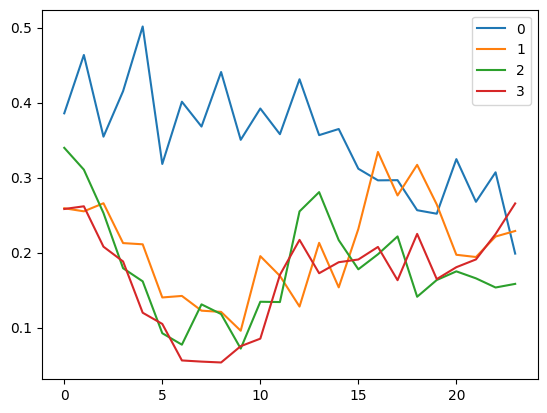

In [94]:
pd.DataFrame(sample.cpu().numpy().squeeze(1).T).plot()